In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
## custom modules
import src.genformer1 as genformer
from src.layers.layers import *
import src.metrics as metrics
import src.optimizers as optimizers
import src.schedulers as schedulers
import src.utils as utils

import training_utils


from scipy import stats



2022-06-17 02:40:20.449703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 02:40:20.449752: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the

In [2]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect('node-16') # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    
mixed_precision.set_global_policy('mixed_bfloat16')
with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    options.deterministic=False
    options.experimental_threading.max_intra_op_parallelism = 1
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 4
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2022-06-17 02:40:34.452409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-17 02:40:34.452477: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-17 02:40:34.452506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-06-17 02:40:34.751760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 02:40:34.764815: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.104.36.98:8470}
2022-06-17 02:40:34.764872: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:44529}
2022-06-17 02:40:34.869861: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.104.36.98:8470}
2022-06-17 02:40:34.869925: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:44529}
2022-06-

INFO:tensorflow:Initializing the TPU system: node-16


INFO:tensorflow:Initializing the TPU system: node-16


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
with strategy.scope():

    train_steps=150
    warmup_steps=10
    val_steps= 10 ### 5562
    num_epochs=50
    lr_base=0.001
    warmup_lr=1.0e-06

    data_it_tr_list = []
    data_it_val_list = []

    ### create dataset iterators
    heads_dict = {}
    orgs = ["hg"]
    for k, org in enumerate(orgs):
        heads_dict[org] = int(k)
    data_dict_tr, data_dict_val = training_utils.return_distributed_iterators(heads_dict,
                                                                              "gs://picard-testing-176520/TSS_164k_82kstride_blacklist0.25_4096outputres_logTPM_prelim_dataset_relaxed/preprocessed_gene_all",
                                                                              GLOBAL_BATCH_SIZE,
                                                                              163840,
                                                                              20,
                                                                              4,
                                                                              num_epochs,
                                                                              strategy,
                                                                              options,
                                                                              "gene",
                                                                              6)



In [4]:
with strategy.scope():
    model = genformer.genformer(kernel_transformation="softmax_kernel_transformation",
                                dropout_rate=0.35,
                                final_out_length=20,
                                num_heads=4,
                                numerical_stabilizer=0.0000001,
                                nb_random_features=256,
                                hidden_size=72,
                                d_model=72,
                                dim=18,
                                max_seq_length = 4096,
                                rel_pos_bins=144,
                                widening = 2, ## ratio between first and second dense layer units in transformer block
                                conv_filter_size=15,
                                #conv_filter_size_2=5,
                                transformer_depth=2,
                                momentum=0.90,
                                channels_list=[18,18,18,18,36,36,36,36,72,72,72],
                                kernel_regularizer=0.001,
                                heads_dict=heads_dict)

In [5]:
with strategy.scope():

    optimizer = tfa.optimizers.AdaBelief(learning_rate=0.0003,
                                         weight_decay=0.000005,
                                         warmup_proportion=0.05,
                                         epsilon=1e-10,
                                         rectify=True,
                                         min_lr=0.000005,
                                         total_steps=4000)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=6, slow_step_size=0.5)

In [6]:
with strategy.scope():
    metric_dict = {}
    train_step, val_step, metric_dict = training_utils.return_train_val_functions_hg(model,
                                                                                     optimizer,
                                                                                     strategy,
                                                                                     metric_dict, 
                                                                                     train_steps,
                                                                                     val_steps,
                                                                                     GLOBAL_BATCH_SIZE,
                                                                                     1.0,
                                                                                     "gene") # last is uncropped length


In [7]:
%matplotlib inline

hg_train_loss: 0.10920578
(4, 20, 1)
(4, 20)
(4, 20, 1)
(4, 20)
hg_val_loss: 0.061706256
hg_val_pearson: 0.01308348
hg_val_R2: -0.5251546
overal gene correlation: -0.038285150056000465


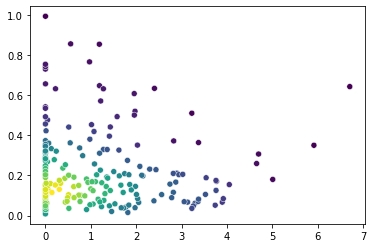

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


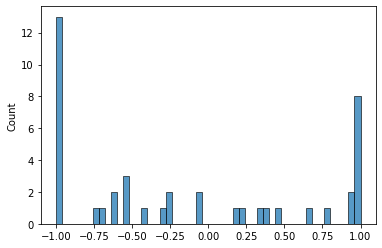

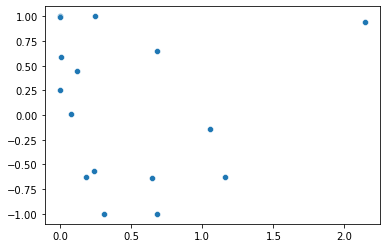

completed epoch 1
duration(mins): 1.845981522401174
patience counter at: 0
hg_train_loss: 0.04328393
hg_val_loss: 0.04219421
hg_val_pearson: -0.029007765
hg_val_R2: -0.6688025
overal gene correlation: 0.021352197396968718


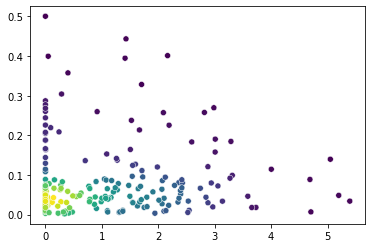

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


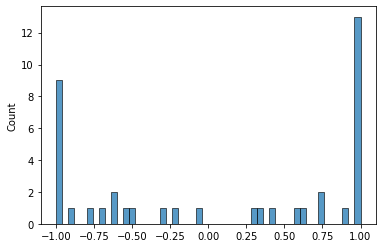

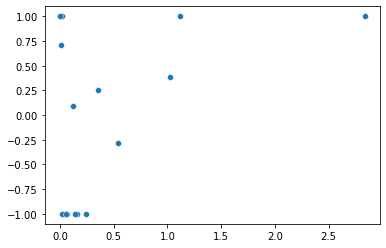

completed epoch 2
duration(mins): 0.19388763507207235
patience counter at: 0


In [ ]:
from scipy.stats.stats import pearsonr  
with strategy.scope():
    
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 10):
        start = time.time()
        train_step(data_dict_tr['hg'])
                   #data_dict_tr['mm'],
                   #data_dict_tr['rm'])
        print('hg_train_loss: ' + str(metric_dict['hg_tr'].result().numpy()))
        val_step(data_dict_val['hg'])#,
                 #data_dict_val['mm']
                 #data_dict_val['rm'])

        val_losses.append(metric_dict['hg_val'].result().numpy())
        print('hg_val_loss: ' + str(metric_dict['hg_val'].result().numpy()))
        print('hg_val_pearson: ' + str(metric_dict['hg_corr_stats'].result()['pearsonR'].numpy()))
        print('hg_val_R2: ' + str(metric_dict['hg_corr_stats'].result()['R2'].numpy()))
        
        #print('hg_val_pearson_gene: ' + str(metric_dict['hg_corr_stats'].result()['feature_level_pearsonR'].numpy()))
        #print('hg_val_R2_gene: ' + str(metric_dict['hg_corr_stats'].result()['feature_level_R2'].numpy()))
        
        y_trues = metric_dict['hg_corr_stats'].result()['y_trues'].numpy()
        y_preds = metric_dict['hg_corr_stats'].result()['y_preds'].numpy()
        cell_types = metric_dict['hg_corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['hg_corr_stats'].result()['gene_map'].numpy()
        
        unique_preds = {}
        unique_trues = {}
        for k,x in enumerate(gene_map):
            if (cell_types[k],x) not in unique_preds.keys():
                unique_preds[(cell_types[k],x)] = []
                unique_trues[(cell_types[k],x)] = []
            else:
                unique_preds[(cell_types[k],x)].append(y_preds[k])
                unique_trues[(cell_types[k],x)].append(y_trues[k])
        
        unique_preds = dict(sorted(unique_preds.items()))
        unique_trues = dict(sorted(unique_trues.items()))
        
        
        #### here we are computing overall correlation
        unique_pred_mean = []
        unique_true_mean = []
        for k,v in unique_preds.items():
            if len(v) > 0:
                unique_pred_mean.append(np.mean(v))
                true_vals = unique_trues[k]
                unique_true_mean.append(np.mean(true_vals))
            else:
                continue
        
        print('overal gene correlation:', pearsonr(unique_pred_mean, 
                                                  unique_true_mean)[0])
        
        data = np.vstack([unique_pred_mean,unique_true_mean])
        kernel = stats.gaussian_kde(data)(data)
        sns.scatterplot(
            x=unique_true_mean,
            y=unique_pred_mean,
            c=kernel,
            cmap="viridis")
        plt.show()
        
        ### now compute correlations across cell types
        across_cells_preds = {}
        across_cells_trues = {}
        
        for k,v in unique_preds.items():
            cell_t,gene_name = k
            if cell_t not in across_cells_preds.keys():
                across_cells_preds[cell_t] = []
                across_cells_trues[cell_t] = []
            else:
                across_cells_preds[cell_t].append(v)
                across_cells_trues[cell_t].append(unique_trues[k])
        cell_specific_corrs = []
        for k,v in across_cells_preds.items():
            trues = []
            preds = []
            for idx,x in enumerate(v):
                if len(x) > 0:
                    preds.append(np.mean(x))
                    trues.append(np.mean(across_cells_trues[k][idx]))
            try: 
                cell_specific_corrs.append(pearsonr(trues, 
                                                    preds)[0])
            except np.linalg.LinAlgError:
                continue
            except ValueError:
                continue
        sns.histplot(x=np.asarray(cell_specific_corrs), bins=50)
        plt.show()
                
            
        ### now compute correlations across genes
        across_genes_preds = {}
        across_genes_trues = {}
        
        for k,v in unique_preds.items():
            cell_t,gene_name = k
            if gene_name not in across_genes_preds.keys():
                across_genes_preds[gene_name] = []
                across_genes_trues[gene_name] = []
            else:
                across_genes_preds[gene_name].append(v)
                across_genes_trues[gene_name].append(unique_trues[k])
        genes_specific_corrs = []
        genes_specific_vars = []
        for k,v in across_genes_preds.items():
            trues = []
            preds = []
            for idx, x in enumerate(v):
                if len(x) > 0:
                    preds.append(np.mean(x))
                    trues.append(np.mean(across_genes_trues[k][idx]))
            try: 
                genes_specific_corrs.append(pearsonr(trues, 
                                                     preds)[0])
                genes_specific_vars.append(np.var(trues))
            except np.linalg.LinAlgError:
                continue
            except ValueError:
                continue
        sns.scatterplot(
            x=genes_specific_vars,
            y=genes_specific_corrs)
        plt.show()

        #print('mm_train_loss: ' + str(metric_dict['mm_tr'].result().numpy()))

        #print('mm_val_loss: ' + str(metric_dict['mm_val'].result().numpy()))
        #print('mm_val_pearson: ' + str(metric_dict['mm_corr_stats'].result()['pearsonR'].numpy()))
        #print('mm_val_R2: ' + str(metric_dict['mm_corr_stats'].result()['R2'].numpy()))
        
        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('duration(mins): ' + str(duration))
    
        print('patience counter at: ' + str(patience_counter))

        for key, item in metric_dict.items():
            item.reset_state()